# **Analyzing Customer Data for a Telecom Company to Predict Churn**

## **Introduction: Project Scope & Purpose**

Our dataset tracks a telco company's customer churn based on a variety of possible factors. Churn means that the customer ended up cancelling their service with the telco company. Our question is: **Can we predict whether a customer will churn by analyzing their relationship with the company?** By building a classification and regression model that predicts whether a customer will churn, the company will have data regarding which customers might churn, and why. The company may use this information to determine to which customers they must allocate resources towards, to minimize churn. This data can be used to make decisions regarding the application of deals or promotions, to maximize their business.

This dataset mostly contains categorical variables such as whether or not a customer is a senior citizen, has phone/internet service, etc. There are a few numeric variables, such as tenure (the number of months the customer has been with the firm) as well as their monthly and total charges paid to the company. The outcome variable is also categorical, churn, and has 2 categories: Yes or No. We need to construct a model with good predictive accuracy when most of our predictors are categorical variables. We will discuss how we approach this challenge in the **Method** section.

## **Preliminary Exploratory Data Analysis**

We begin this process by reading our raw data from its' web source into R. We do so below:

In [34]:
set.seed(1984)
library(tidyverse)
library(tidymodels)
library(readxl)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


In [2]:
url <- "https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/CustomerChurn.xlsx"

download.file(url, "Churn_Data.xlsx")

churn_data <- read_excel("Churn_Data.xlsx")
head(churn_data)

LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,⋯,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
160192,9305-CDSKC,No,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


*Table 1*

We are fortunate enough that our data is already mostly in tidy format, and what remains is to change the categorization of certain varibles (e.g. from "chr" to "fct") as well as make sure the columns include periods instead of spaces.

In [3]:
colnames(churn_data) <- make.names(colnames(churn_data))

In [4]:
churn_data_vars <- churn_data %>%
    mutate(across(Senior.Citizen:Dependents, as.factor))%>%
    mutate(across(Phone.Service:Payment.Method,as.factor))%>%
    mutate(Churn=as.factor(Churn))%>%
    select(-LoyaltyID,-Customer.ID)
head(churn_data_vars)


Senior.Citizen,Partner,Dependents,Tenure,Phone.Service,Multiple.Lines,Internet.Service,Online.Security,Online.Backup,Device.Protection,Tech.Support,Streaming.TV,Streaming.Movies,Contract,Paperless.Billing,Payment.Method,Monthly.Charges,Total.Charges,Churn
<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


*Table 2*

In [5]:
#Splitting data into training and testing purposes
churn_split <- initial_split(churn_data_vars, prop=0.75, strata=Churn)
churn_train <- training(churn_split)
churn_test <- testing(churn_split)

## **Summarizing Our Data in a Table**

Given that we both have quantitative and categorical data, it is hard to summarize the whole dataset in one table, so we will be doing several, each analyzing different variables. Feel free to refer to the 1st section of the **Methods** portion of our proposal for our explanation for why we chose these variables

In [6]:
#Analyzing tenure and monthly charges by churn and non-churn customers
churn_tenure_charge <-churn_train %>%
    group_by(Churn)%>%
    summarise(across(c("Tenure", "Monthly.Charges"), mean))%>%
    rename(Mean.Tenure=Tenure)%>%
    rename(Mean.Monthly.Charges=Monthly.Charges)
    
churn_tenure_charge

`summarise()` ungrouping output (override with `.groups` argument)



Churn,Mean.Tenure,Mean.Monthly.Charges
<fct>,<dbl>,<dbl>
No,37.49601,61.14415
Yes,18.22040,74.82874


*Table 3*

In [7]:
#Analyzing which proportion of customers are senior citizens, have a phone service, or have an internet service (Yes = they fall into that category)

senior_share <-churn_train %>%
       count(Senior.Citizen) %>%
       mutate(Yes_No=Senior.Citizen,)%>%
        relocate(Yes_No)

phone_service_share <-churn_train %>%
       count(Phone.Service)%>%
        mutate(Yes_No=Phone.Service,)%>%
        relocate(Yes_No)

internet_service_share <-churn_train %>%
    mutate(Internet.Service=as.character(Internet.Service))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="DSL", "Yes")) %>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="Fiber optic", "Yes"))%>%
    count(Internet.Service)%>%
    mutate(Yes_No= Internet.Service)%>%
        relocate(Yes_No)


customer_share <- senior_share %>%
    full_join(phone_service_share, by="Yes_No")%>%
    full_join(internet_service_share, by="Yes_No")%>%
    select(Yes_No,n.x,n.y,n)%>%
    rename("Senior Citizen"=n.x)%>%
    rename("Phone.Service"=n.y)%>%
    rename("Internet.Service"=n)
    
customer_share

Yes_No,Senior Citizen,Phone.Service,Internet.Service
<chr>,<int>,<int>,<int>
No,4433,510,1127
Yes,850,4773,4156


*Table 4*

In [8]:
#Looking at customer contract distribution

contract_share <- churn_train %>%
    count(Contract)
contract_share

Contract,n
<fct>,<int>
Month-to-month,2923
One year,1089
Two year,1271


*Table 5*

In [9]:
#Looking at customer payment method distribution

payment_share <- churn_train %>%
    count(Payment.Method)
payment_share

Payment.Method,n
<fct>,<int>
Bank transfer (automatic),1163
Credit card (automatic),1131
Electronic check,1776
Mailed check,1213


*Table 6*

## **Visualizing Data**

Here we look at the distribution of tenure between current and churned customers.

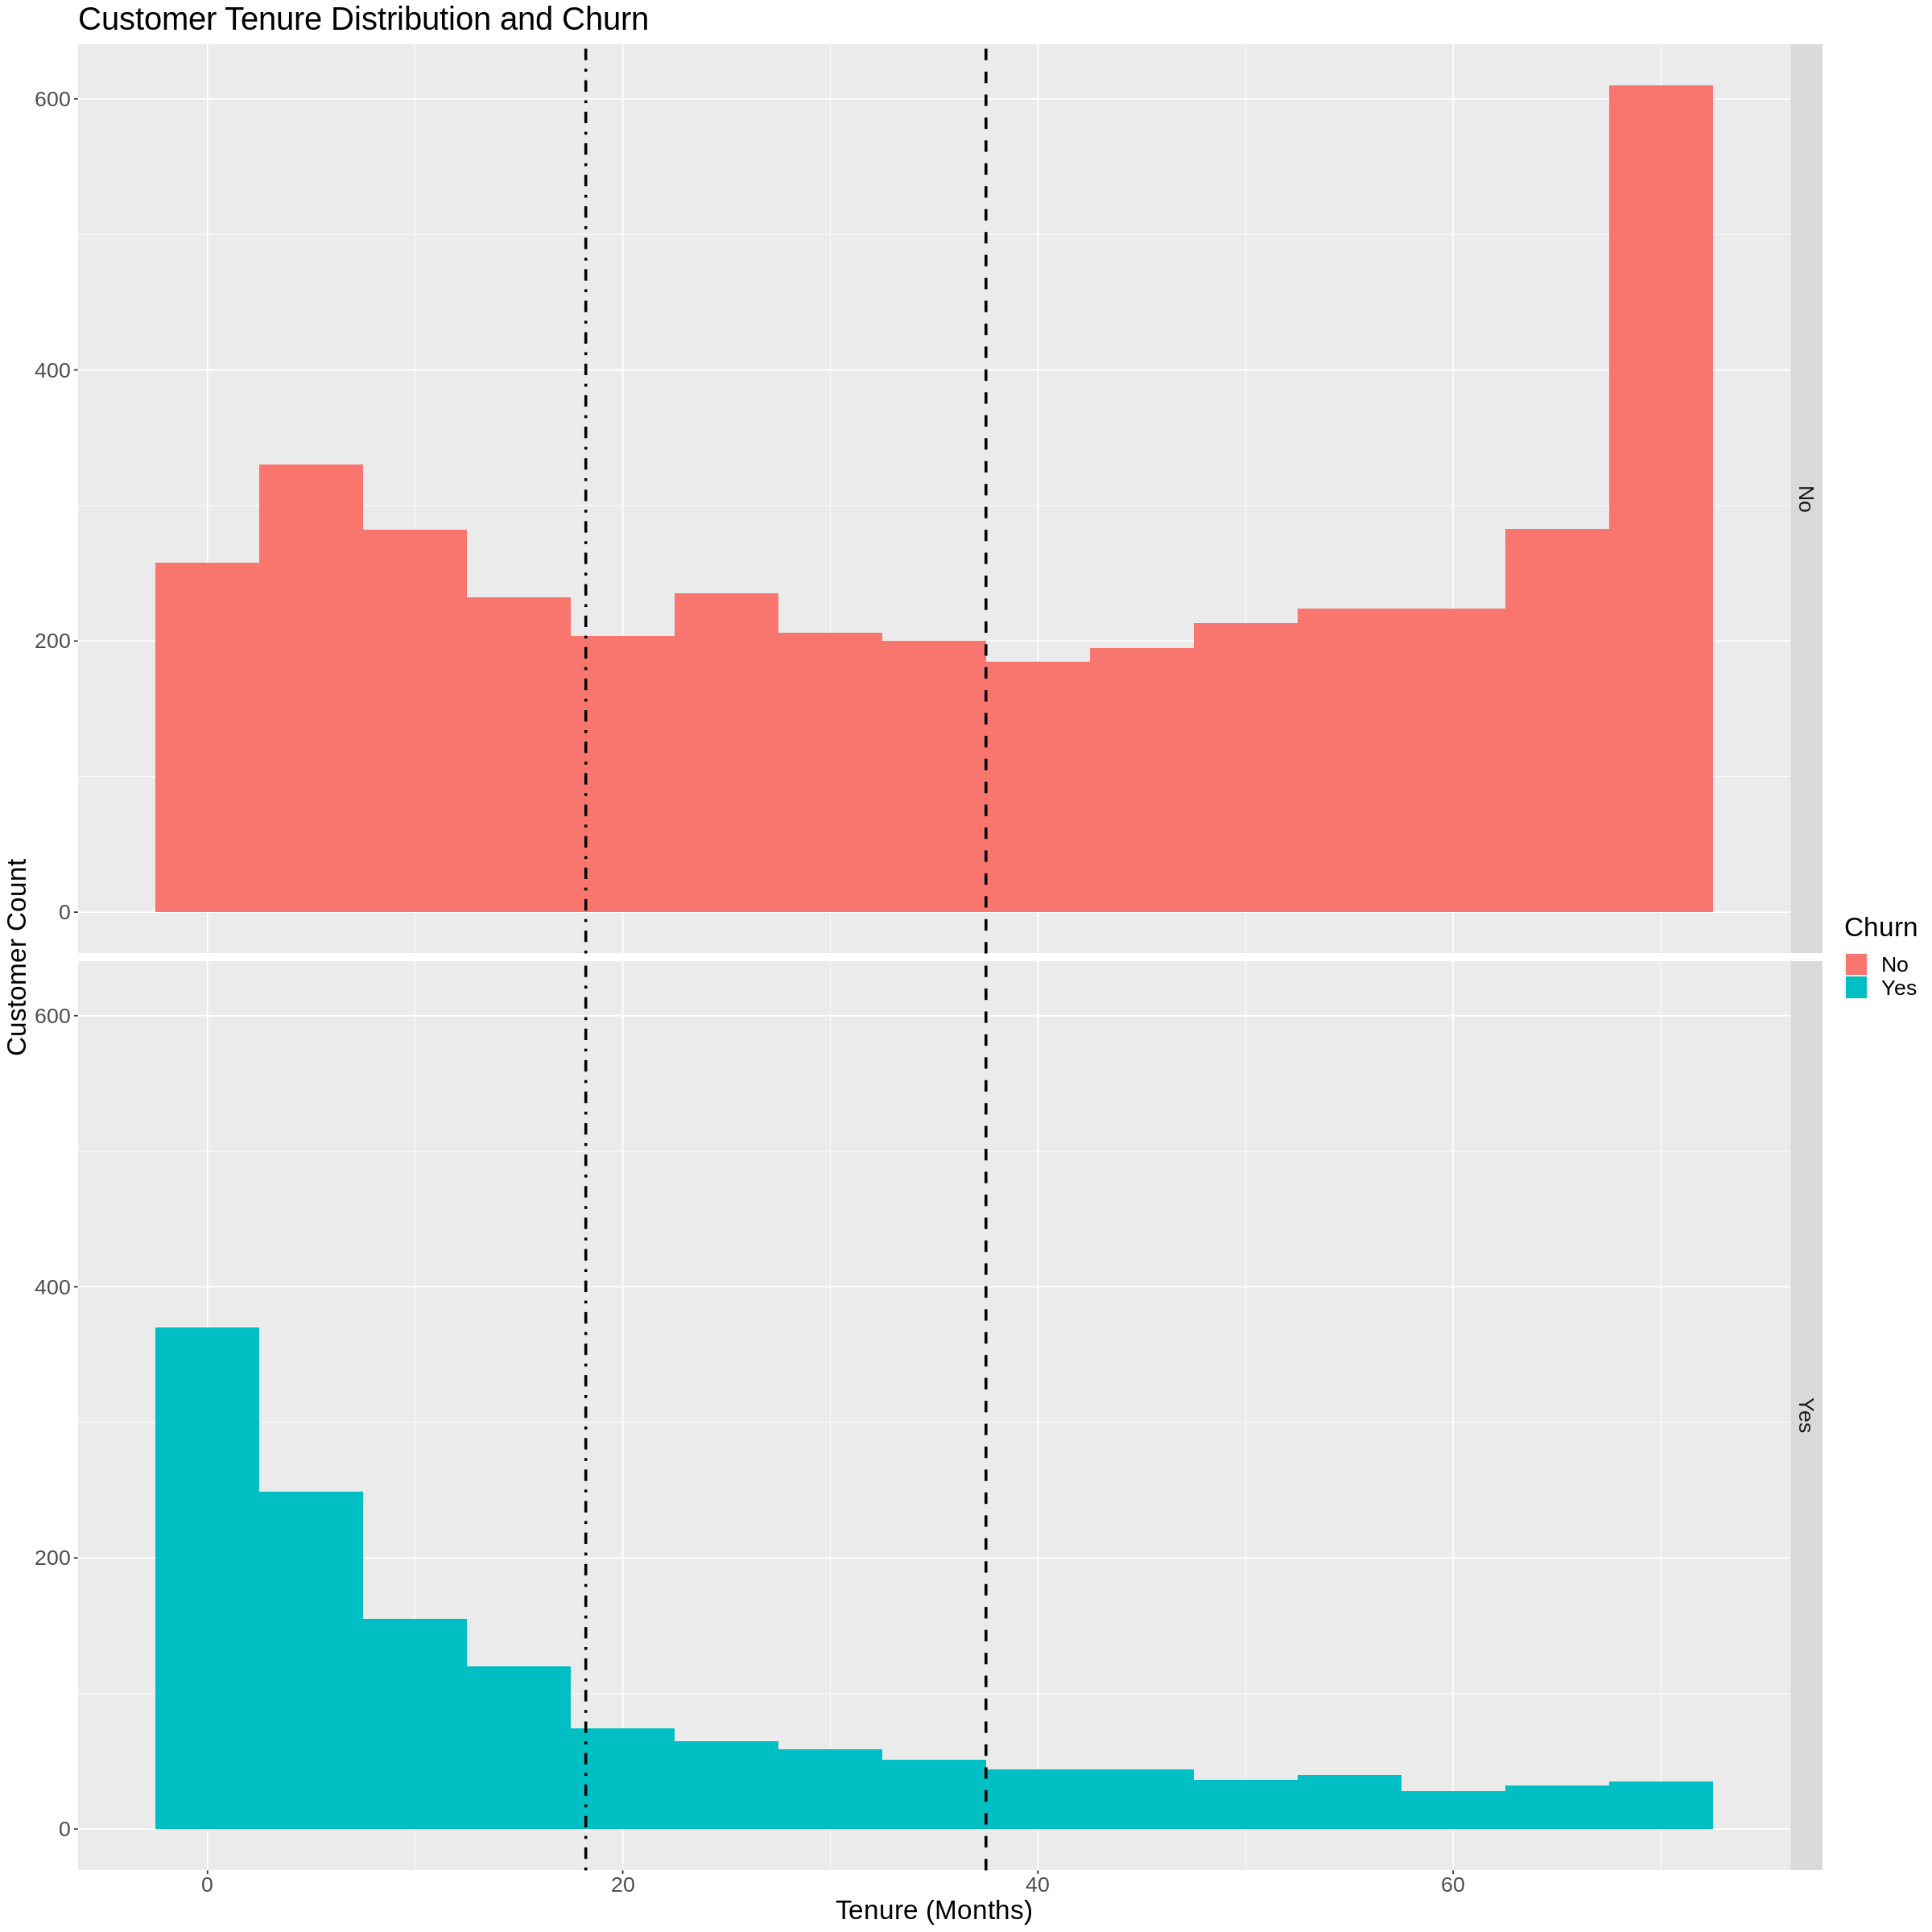

In [10]:
options(repr.plot.width = 20, repr.plot.height = 20)

tenure_dist <- churn_train %>%
    ggplot(aes(x=Tenure, fill=Churn))+
    geom_histogram(position="identity", binwidth=5)+
    facet_grid(Churn ~.)+
    theme(text=element_text(size=20))+
    labs(x="Tenure (Months)",y="Customer Count",fill="Churn")+
    ggtitle("Customer Tenure Distribution and Churn")+
    geom_vline(xintercept=pull(filter(churn_tenure_charge,Churn=="No"),Mean.Tenure),linetype="dashed",size=1.0)+
    geom_vline(xintercept=pull(filter(churn_tenure_charge,Churn=="Yes"),Mean.Tenure),linetype="dotdash",size=1.0)

tenure_dist

#dotdash = mean for churned customers, dash= mean for current customers


*Figure 1*

## **Methods**

We have chosen 7 predictor variables: 
* Tenure
* Phone Service
* Internet Service
* Contract
* Payment Method
* Monthly Charges
* Senior Citizen

Monthly charges are important as it can be a large expense for customers. Phone/Internet service is why the customer signed with the telco company in the first place. Tenure measures how long (in months) the customer has been with the company (shows customer loyalty). Lastly, we believe senior citizens may be less likely to churn as they may not be as technologically concerned as younger customers.

Contract type (monthly, yearly, two-year) is important as it shows how committed the customer is to the telco company. Payment is important because automatic transfers may have a lower psychological impact on retention.

In [11]:
churn_train_predictors <- churn_train %>%
    select(Tenure, Phone.Service,Internet.Service,Contract,Payment.Method,Monthly.Charges,Senior.Citizen,Churn)
head(churn_train_predictors)

Tenure,Phone.Service,Internet.Service,Contract,Payment.Method,Monthly.Charges,Senior.Citizen,Churn
<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
1,No,DSL,Month-to-month,Electronic check,29.85,No,No
34,Yes,DSL,One year,Mailed check,56.95,No,No
2,Yes,DSL,Month-to-month,Mailed check,53.85,No,Yes
45,No,DSL,One year,Bank transfer (automatic),42.30,No,No
2,Yes,Fiber optic,Month-to-month,Electronic check,70.70,No,Yes
8,Yes,Fiber optic,Month-to-month,Electronic check,99.65,No,Yes


*Table 7*

## **Data Analysis - KNN Classification**

First, we will transform our training and testing data set into a format that is conducive to a K-NN Classification model. All variables that have a "Yes" or "No" option will be transformed into a 0 or 1 (0 means No, 1 means Yes). For cateogorical variables with more than two outcomes (i.e, Contract and Payment Method), we will choose one digit to represent one category. 

**Contract Type**

* Month-To-Month = 0
* 1-Year = 1
* 2 Year = 2

**Payment Method**
* Bank transfer (automatic) = 0
* Credit card (automatic) = 1
* Electronic check = 2
* Mailed check = 3

After having completed the transformation of both data sets, we will proceed with constructing the classification model. This includes creating the prediction recipe, outlining model specifications, and setting cross validation parameters. Given the large  number of observations we have, we will use a 5-fold parameter that tests values for k from 1-50 to reduce computation time. 

We will then collect metrics from our cross-validation and create an accuracy plot to see which k yields us the highest expected accuracy. We will then construct a new model specfication with the optimized k value and create a workflow using the existing recipe to predict the testing set.

The model predictions will be compared to the true values to assess the accuracy of our classifier. A confusion matrix will also be used to see how many false positives and false negatives were predicted. We will then create a visualization using our quantitative variables to visually see how accurate our classifier is by comparing side-by-side graphs of predicted churn and true churn.

*Note: We wanted to originally also conduct a linear regression but given that our outcome variable would be a dummy, we would not be able to analyze in the same way we were taught in the course and so we decided to stick with the classification model exclusively*

In [12]:
#Changing categorical variables into dummy varibles

#We are just considering whether or not a client has internet, so the type of internet they have is irrelevant for our analysis

churn_dummy <- churn_train_predictors %>%
    mutate(Internet.Service=as.character(Internet.Service))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="DSL", 1))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="Fiber optic", 1))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="No", 0))%>%
    mutate(Internet.Service=as.numeric(Internet.Service)) 
   
churn_dummy <- churn_dummy %>%
    mutate(Phone.Service=as.character(Phone.Service))%>%
    mutate(Phone.Service=replace(Phone.Service, Phone.Service=="Yes", 1))%>%
    mutate(Phone.Service=replace(Phone.Service, Phone.Service=="No", 0))%>%
    mutate(Phone.Service=as.numeric(Phone.Service))  
   
churn_dummy <- churn_dummy %>%
    mutate(Senior.Citizen=as.character(Senior.Citizen))%>%
    mutate(Senior.Citizen=replace(Senior.Citizen, Senior.Citizen=="No", 0))%>%
    mutate(Senior.Citizen=replace(Senior.Citizen, Senior.Citizen=="Yes", 1))%>%
    mutate(Senior.Citizen=as.numeric(Senior.Citizen))    
   
churn_dummy <- churn_dummy %>%
    mutate(Payment.Method=as.character(Payment.Method))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Bank transfer (automatic)", 0))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Credit card (automatic)", 1))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Electronic check", 2))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Mailed check", 3))%>%  
    mutate(Payment.Method=as.numeric(Payment.Method)) 
   
churn_dummy <- churn_dummy %>%   
    mutate(Contract=as.character(Contract)) %>%
    mutate(Contract=replace(Contract, Contract=="Month-to-month", 0))%>%
    mutate(Contract=replace(Contract, Contract=="One year", 1))%>%
    mutate(Contract=replace(Contract, Contract=="Two year", 2))%>%
    mutate(Contract=as.numeric(Contract)) 

head(churn_dummy)
    

Tenure,Phone.Service,Internet.Service,Contract,Payment.Method,Monthly.Charges,Senior.Citizen,Churn
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,1,0,2,29.85,0,No
34,1,1,1,3,56.95,0,No
2,1,1,0,3,53.85,0,Yes
45,0,1,1,0,42.30,0,No
2,1,1,0,2,70.70,0,Yes
8,1,1,0,2,99.65,0,Yes


*Table 8*

In order for the classification model work properly, we must also transform the same variables in the testing database into the same format, which we do below:

In [24]:
#Converting testing data into similar format for prediction to work in R
#This step is identitical to the one above except that it is performed on the testing set

churn_test_clean <- churn_test %>%
    mutate(Internet.Service=as.character(Internet.Service))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="DSL", 1))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="Fiber optic", 1))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="No", 0))%>%
    mutate(Internet.Service=as.numeric(Internet.Service)) 
   
churn_test_clean <- churn_test_clean %>%
    mutate(Phone.Service=as.character(Phone.Service))%>%
    mutate(Phone.Service=replace(Phone.Service, Phone.Service=="Yes", 1))%>%
    mutate(Phone.Service=replace(Phone.Service, Phone.Service=="No", 0))%>%
    mutate(Phone.Service=as.numeric(Phone.Service))  
   
churn_test_clean <- churn_test_clean %>%
    mutate(Senior.Citizen=as.character(Senior.Citizen))%>%
    mutate(Senior.Citizen=replace(Senior.Citizen, Senior.Citizen=="No", 0))%>%
    mutate(Senior.Citizen=replace(Senior.Citizen, Senior.Citizen=="Yes", 1))%>%
    mutate(Senior.Citizen=as.numeric(Senior.Citizen))    
   
churn_test_clean <- churn_test_clean %>%
    mutate(Payment.Method=as.character(Payment.Method))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Bank transfer (automatic)", 0))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Credit card (automatic)", 1))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Electronic check", 2))%>%
    mutate(Payment.Method=replace(Payment.Method, Payment.Method=="Mailed check", 3))%>%  
    mutate(Payment.Method=as.numeric(Payment.Method)) 
   
churn_test_clean <- churn_test_clean %>%
    mutate(Contract=as.character(Contract)) %>%
    mutate(Contract=replace(Contract, Contract=="Month-to-month", 0))%>%
    mutate(Contract=replace(Contract, Contract=="One year", 1))%>%
    mutate(Contract=replace(Contract, Contract=="Two year", 2))%>%
    mutate(Contract=as.numeric(Contract)) 

churn_test_clean <- churn_test_clean %>%
    select(Internet.Service, Phone.Service, Senior.Citizen, Payment.Method,Contract,Tenure,Monthly.Charges,Churn)

head(churn_test_clean)

Internet.Service,Phone.Service,Senior.Citizen,Payment.Method,Contract,Tenure,Monthly.Charges,Churn
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,0,2,0,28,104.80,Yes
1,1,0,2,0,21,90.05,No
0,1,0,3,0,1,20.15,Yes
1,1,0,1,0,49,59.60,No
1,0,0,2,0,1,30.20,Yes
1,1,1,1,0,2,95.50,No


*Table 9*

We will now construct our cross-validation model to assess which k value results in the highest recorded accuracy

In [15]:
#Building training recipe

churn_recipe <- recipe(Churn ~., data=churn_dummy)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

#Building model specifications

churn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

#Setting cross validation parameters

churn_vfold <- vfold_cv(churn_dummy, v=5, strata=Churn)

#Setting values for k
k_vals <- tibble(neighbors=seq(from=1,to=50,by=1))

#Building workflow
churn_results <- workflow()%>%
    add_recipe(churn_recipe)%>%
    add_model(churn_spec)%>%
    tune_grid(resamples=churn_vfold,grid=k_vals)%>%
    collect_metrics()

head(churn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7376520,5,0.006150596,Model01
1,roc_auc,binary,0.6683731,5,0.007083946,Model01
2,accuracy,binary,0.7382200,5,0.006017705,Model02
2,roc_auc,binary,0.7227353,5,0.006127673,Model02
3,accuracy,binary,0.7690737,5,0.004955375,Model03
3,roc_auc,binary,0.7566331,5,0.008245145,Model03


*Table 10*

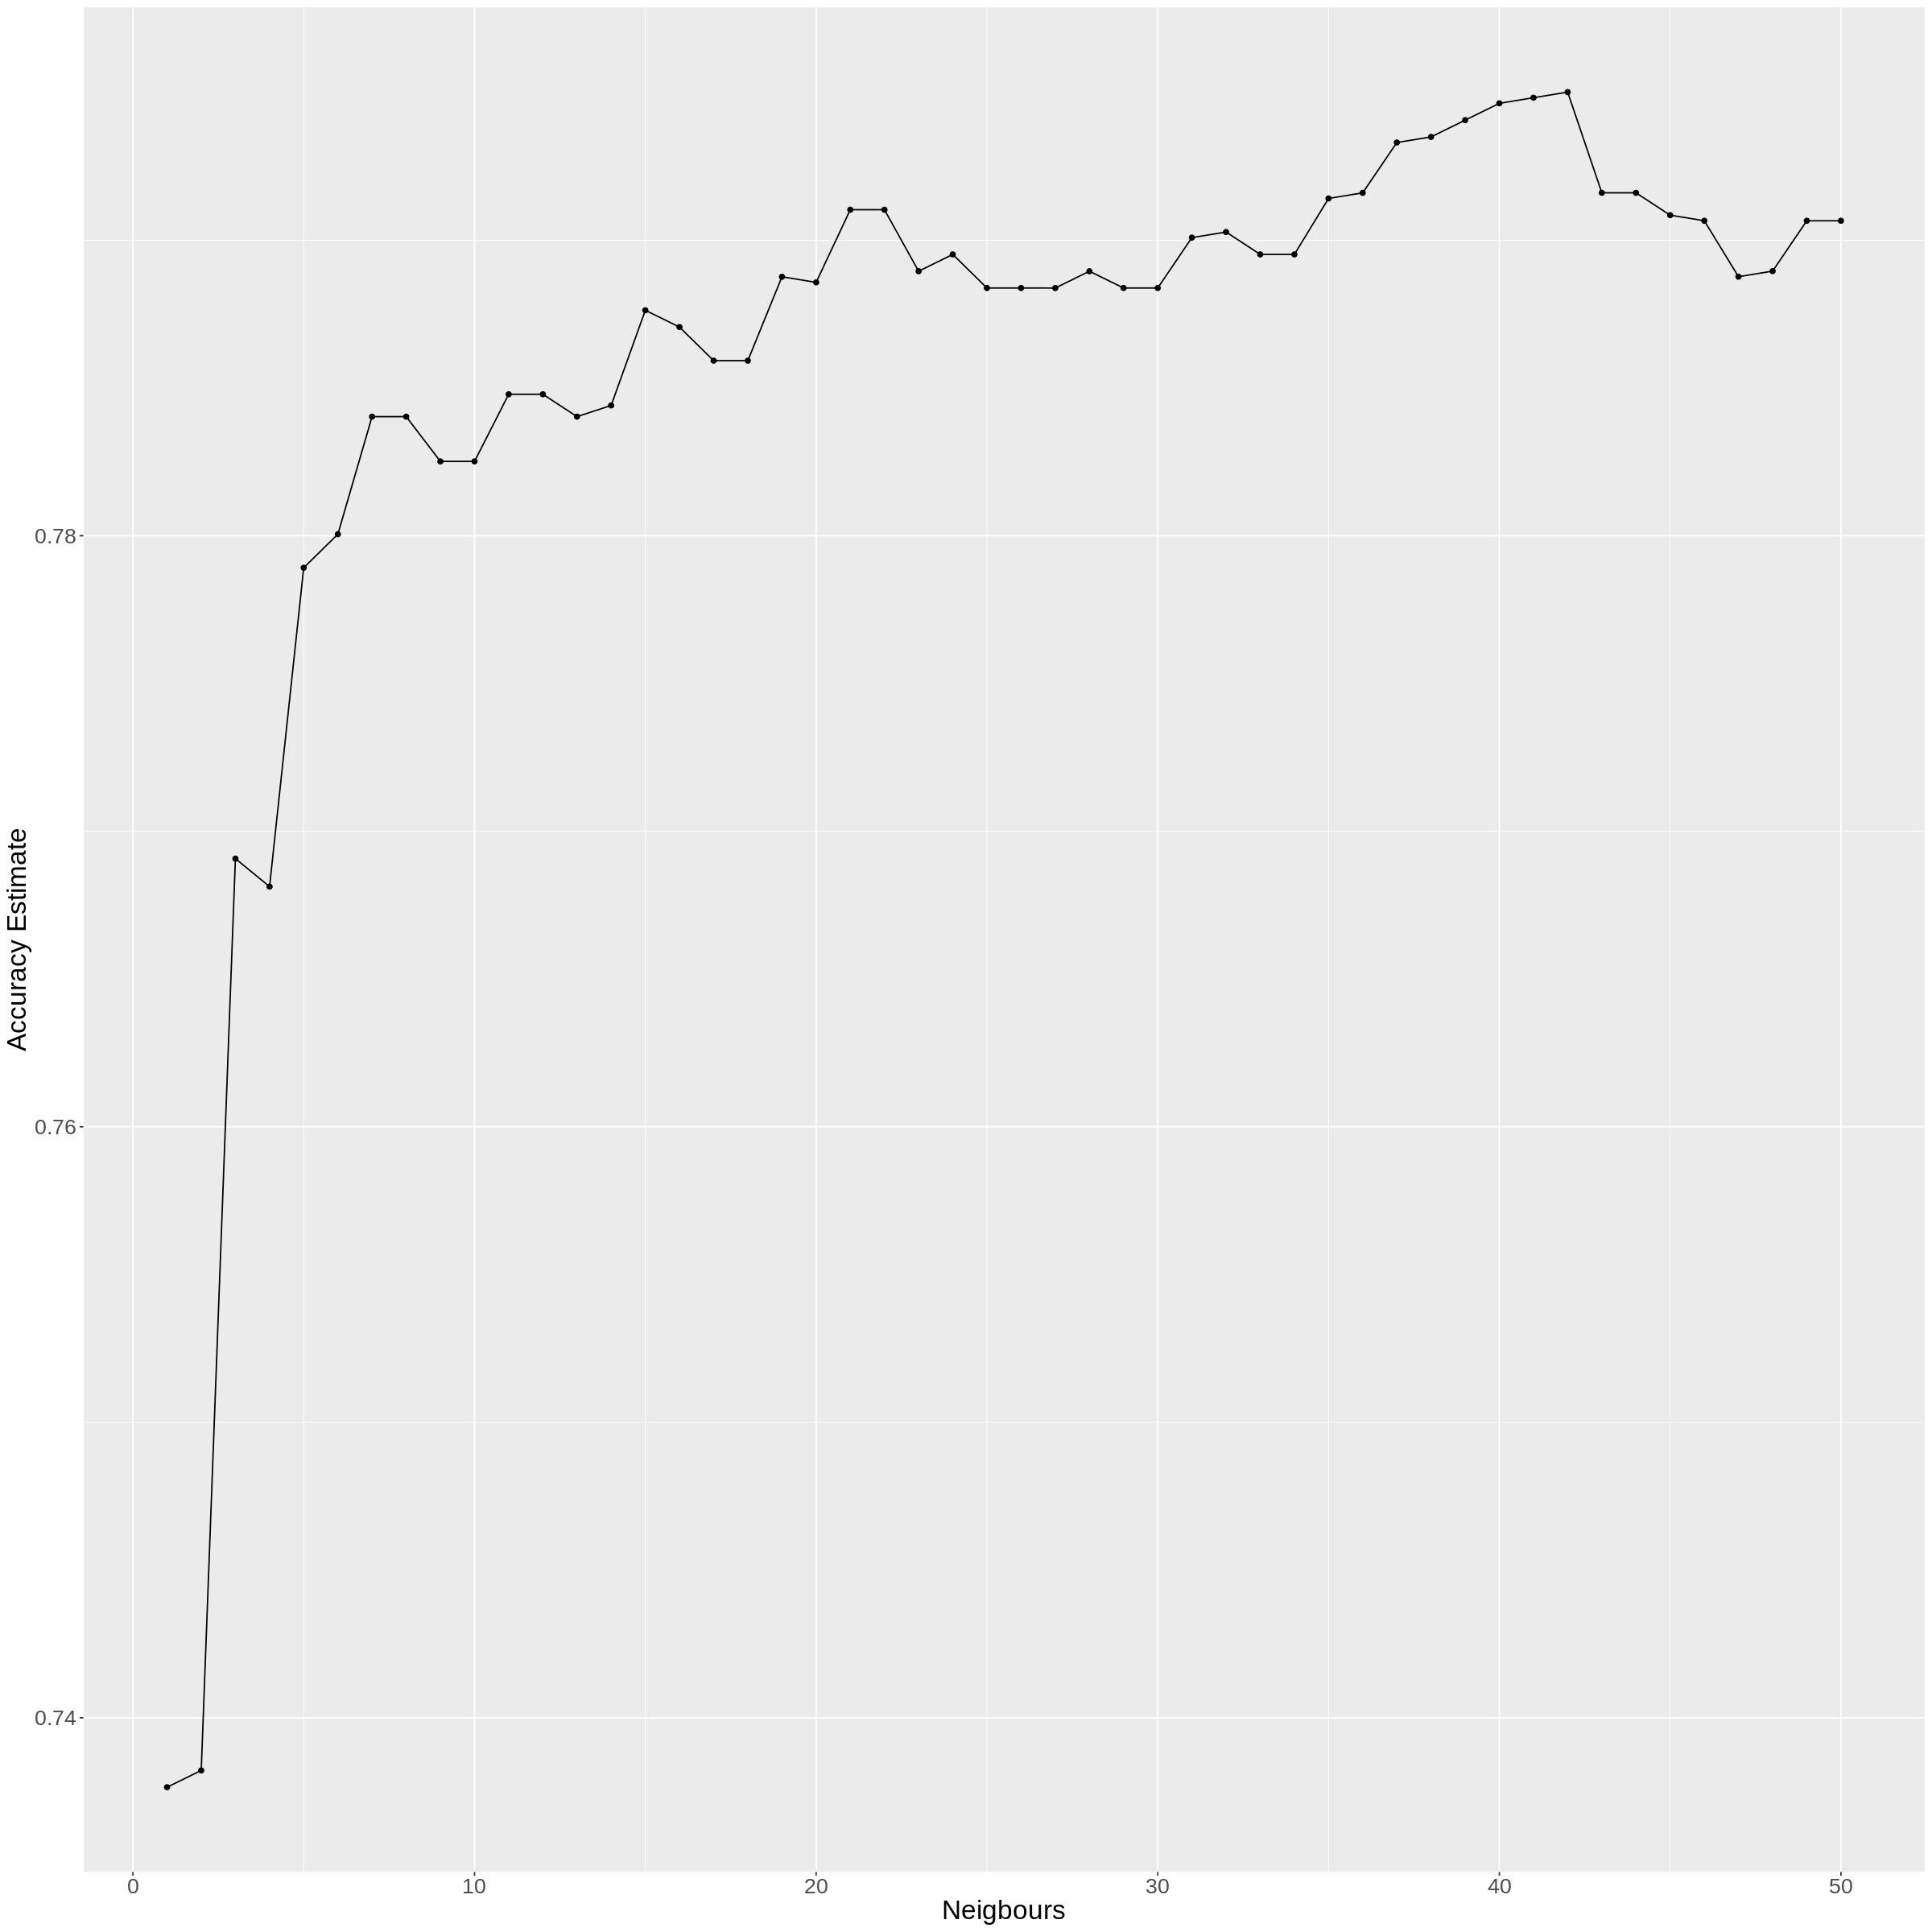

In [16]:
#Plotting for accuracy

accuracies <- churn_results %>%
    filter(.metric=="accuracy")

accuracy_plot <- accuracies %>%
    ggplot(aes(x=neighbors,y=mean))+
    geom_point()+
    geom_line()+
    labs(x="Neigbours", y="Accuracy Estimate")+
    theme(text=element_text(size=20))

accuracy_plot

*Figure 2*

**Choosing K**

As we can see with the graph above, a k value of 41 provides the best accuracy at around 79%. We will use k=41 as our k input for the testing data and construct the predictive model for the testing set

In [60]:
#Building testing model specifications

churn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=48)%>%
    set_engine("kknn")%>%
    set_mode("classification")


#Building workflow
churn_fit <- workflow()%>%
    add_recipe(churn_recipe)%>%
    add_model(churn_spec)%>%
    fit(data = churn_dummy)

#Predicting testing data
churn_predictions <- predict(churn_fit,churn_test_clean) %>%
    bind_cols(churn_test_clean)

head(churn_predictions)



.pred_class,Internet.Service,Phone.Service,Senior.Citizen,Payment.Method,Contract,Tenure,Monthly.Charges,Churn
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Yes,1,1,0,2,0,28,104.80,Yes
Yes,1,1,0,2,0,21,90.05,No
No,0,1,0,3,0,1,20.15,Yes
No,1,1,0,1,0,49,59.60,No
Yes,1,0,0,2,0,1,30.20,Yes
Yes,1,1,1,1,0,2,95.50,No


*Table 11*

We will now assess the accuracy of the classifier

In [62]:
#Assessing classifier accuracy

churn_predictions_accuracy <- churn_predictions %>%
    metrics(truth=Churn, estimate=.pred_class)%>%
    filter(.metric=="accuracy")

churn_predictions_accuracy
    

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7920455


*Table 12*

We will look at the confusion matrix as well

In [61]:
#Confusion matrix

churn_conf<- churn_predictions %>%
    conf_mat(truth=Churn,estimate=.pred_class)

churn_conf


          Truth
Prediction   No  Yes
       No  1161  234
       Yes  132  233

*Table 13*

## **Post Analysis Visualization**

We will use our two numeric variables (Tenure and Monthly Charges) to create a plot that is coloured based on what the classifier predicted Churn would be and compare it to the true values

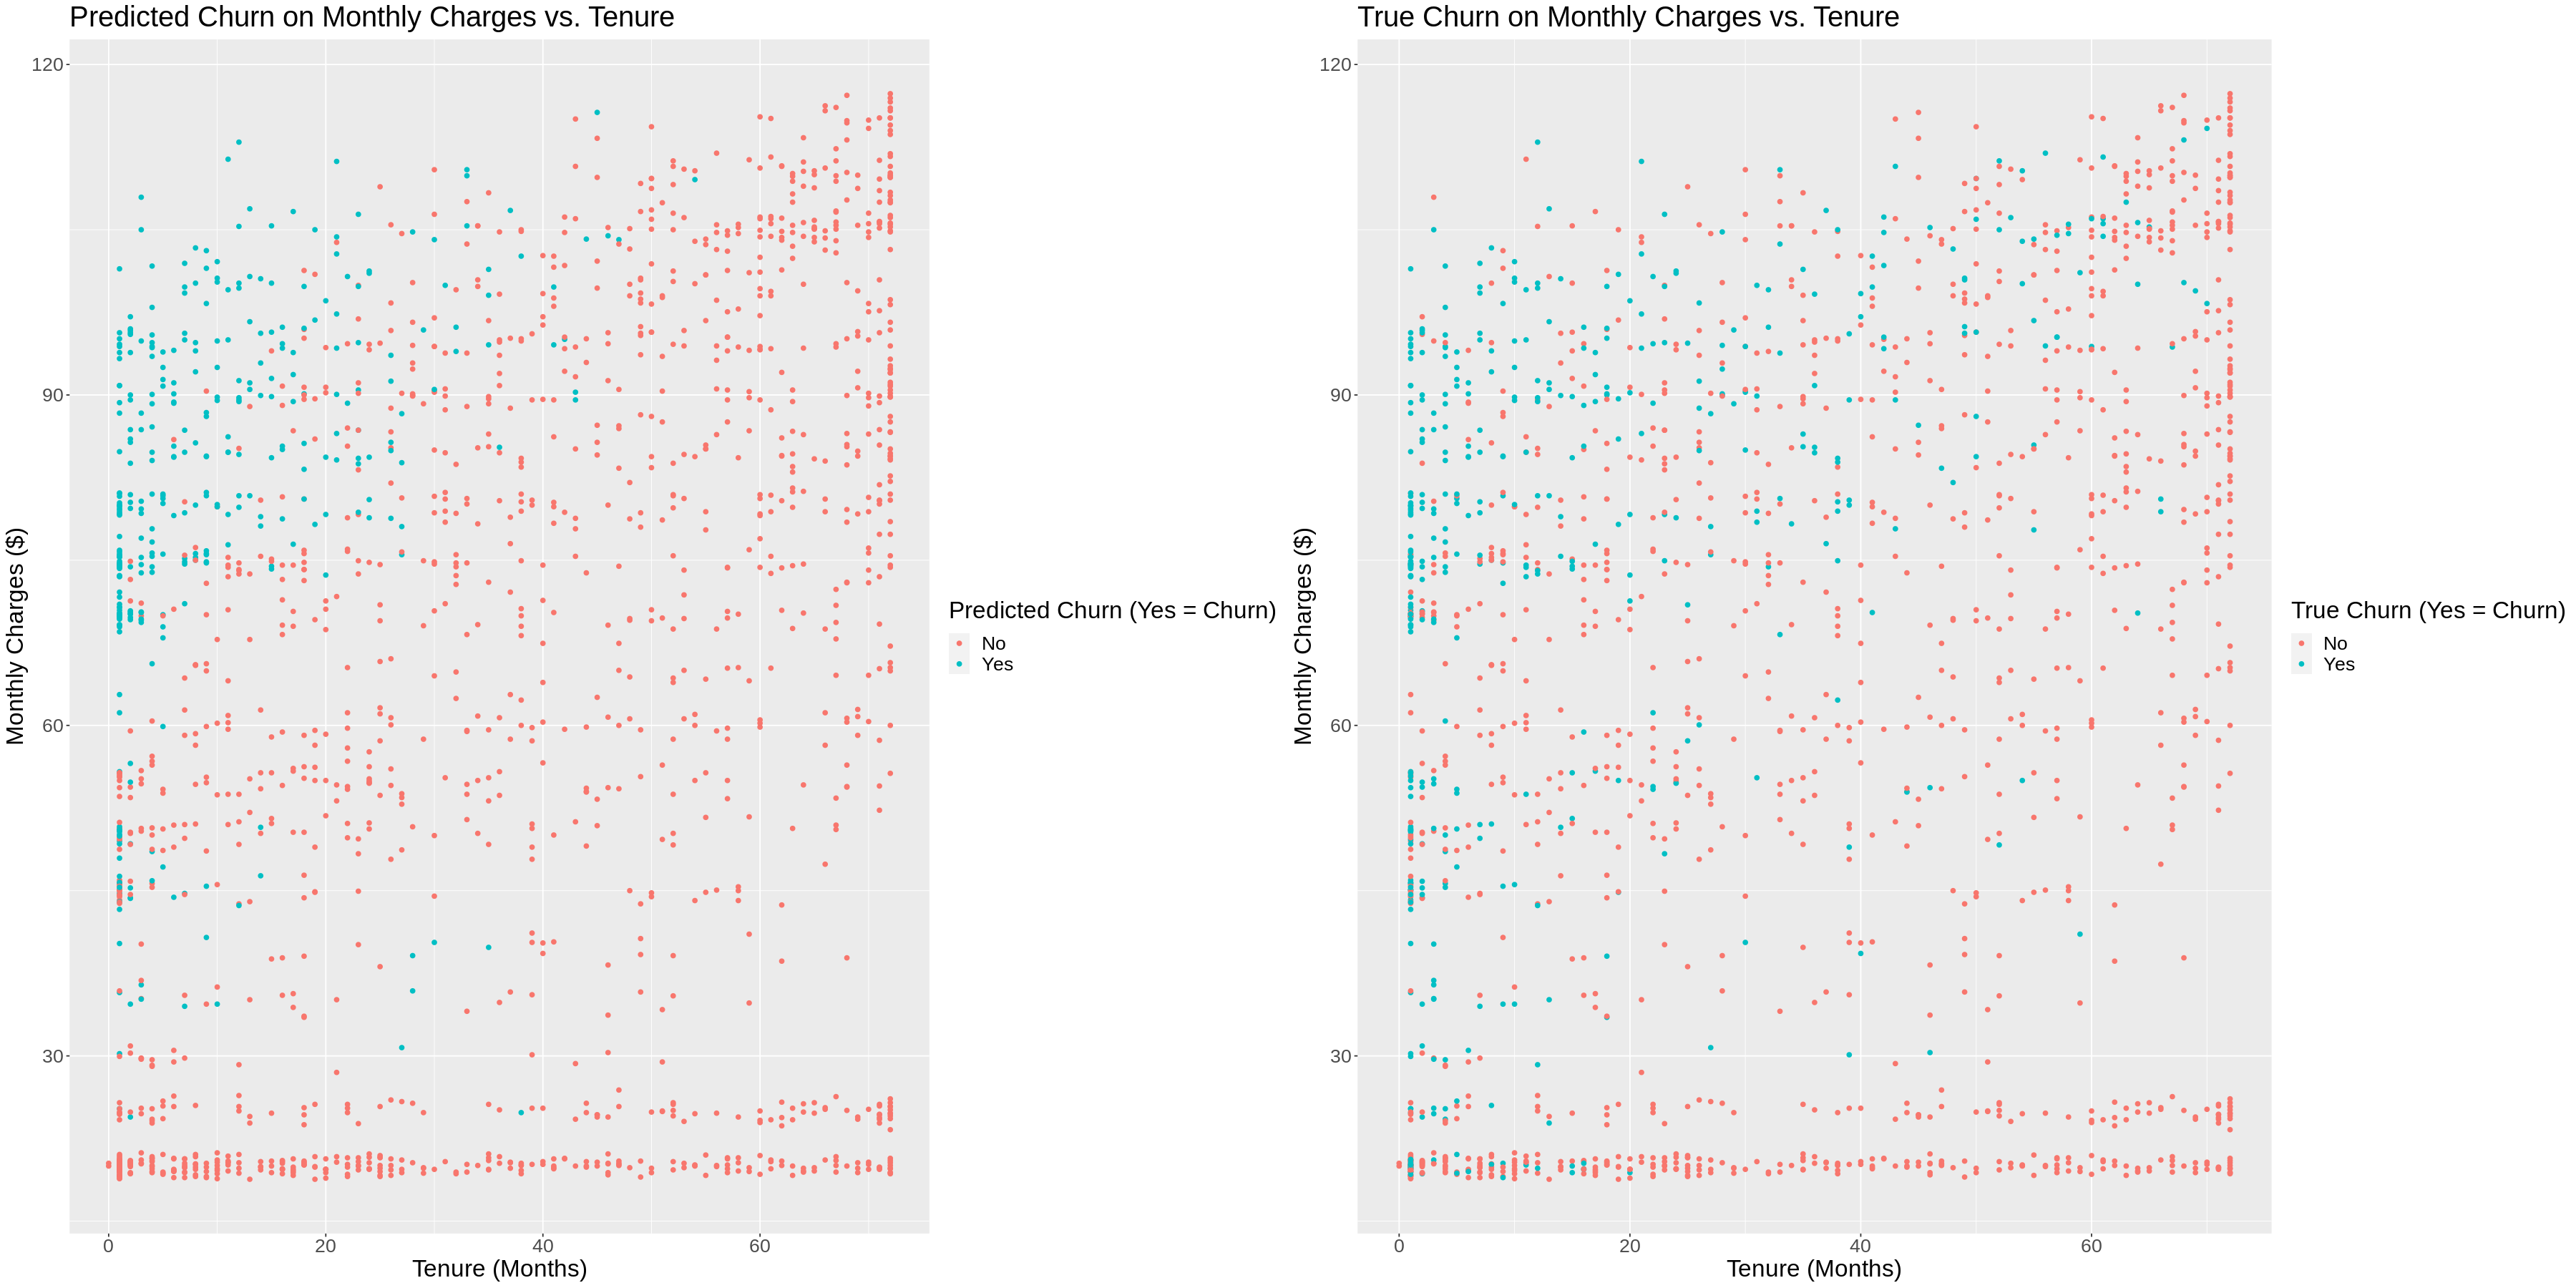

In [42]:
options(repr.plot.width = 30, repr.plot.height = 15)
tenurecharges_pred <- churn_predictions %>%
    ggplot(aes(x=Tenure, y=Monthly.Charges, color=.pred_class))+
    geom_point()+
    theme(text=element_text(size=20))+
    labs(x="Tenure (Months)",y="Monthly Charges ($)",color="Predicted Churn (Yes = Churn)")+
    ggtitle("Predicted Churn on Monthly Charges vs. Tenure")
    
tenurecharges_true <- churn_predictions %>%
    ggplot(aes(x=Tenure, y=Monthly.Charges, color=Churn))+
    geom_point()+
    theme(text=element_text(size=20))+
    labs(x="Tenure (Months)",y="Monthly Charges ($)",color="True Churn (Yes = Churn)")+
    ggtitle("True Churn on Monthly Charges vs. Tenure")

plot_grid(tenurecharges_pred, tenurecharges_true)


*Figure 3*

## **Discussion**

Having now completed our model, we can confidently say that, yes, we can predict customer churn based on customers' relationships with the Telco company. 
Our model predicts with an accuracy of approximately 79% (Table 12), which, in the context of this data analysis question, can be considered accurate enough to be reliable, especially considering the number of variables that go into determining churn. As this data pertains to the allocation of company resources to maximize profit, and not a scenario that requires significantly higher prediction accuracy (life-or-death), this classifier is accurate enough. 
Referring to Table 13, we see the number of false positives and negatives generated by our classifier. A false positive is when the  We note that it generates more false positives than negatives, which, in our context, is better, as it is safer for the company to assume churn than not. In the event that the classifier predicts churn when, in fact, a customer does not intend to part ways with the company, the company will simply advertise, or promote a deal to a person who does not necessarily need it. In the event that the classifier predicts a false negative, the company loses business.
Looking at Figure 3, we note that the model predicts slightly too much churn for new customers, and slightly too little for long term customers, which will only reduce efficiency slightly, as discussed previously. It still predicts approximately 4/5 cases correctly. Additionally, it aids greatly in predicting the intermediate cases, which appear more ambiguous without the use of a classifier.
Note that in Figure 3, the visualizations were created using only two of the seven chosen predictor variables. As such, these issues in prediction exist likely as a result of not having considered the others. It is simply difficult to visualize all of the other variables, as they are categorical (meaning they will not generate meaningful scatterplots).
    
Generally speaking, we expected that each of the variables we chose would be important predictors of churn, which our analysis confirms. Refer to the "Methods" section of this document for our initial rationale behind choosing these variables. Our model's accuracy supports our initial rationale. 

Our model will help the company understand which customers it needs to focus its resources on to reduce churn. Applying the classifier's predictions, the company can implement a proactive strategy of addressing customer needs before they want to leave the company, confident that the model identifies the correct people to target. To attempt to prevent churn, the company might reach out to customers with high churn potential with special offers or deals otherwise not given, which may prevent them from leaving. 

Potential questions for further research:
   * Why are customers that have recently joined more likely to leave than older customers?
   * For customers who have remained a long time, why have they left?
   * What age group of customers are the most loyal (or on the other hand, most likely to churn)

How we could potentially improve our classifier:
   * Testing higher K values (not done here, as was resource intensive, but there could potentially be a K value greater than 41 with higher accuracy)
   * Using 10-fold cross validation, not 5-fold

## **References**

* Data: IBM. (2021, July 14). Customer Churn Data: https://community.ibm.com/accelerators/catalog/content/Customer-churn

* Hanck, C., Arnold, M., Gerber, A., & Schmelzer, M. (2021, October 6). Regression with a Binary Dependent Variable. Retrieved from Introduction to Econometrics with R: https://www.econometrics-with-r.org/
* Princeton University. (2007). Working With Dummy Variables. Retrieved from Princeton University Library: https://dss.princeton.edu/online_help/analysis/dummy_variables.htm